# Real-world Data Wrangling

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
import warnings
import urllib3
from sklearn.preprocessing import MinMaxScaler

## 1. Gather data


### **1.1.** Problem Statement
This project investigates a potential correlation between the number of deaths by suicide and the size of the Powerball lottery jackpot. The hypothesis is that there may be an increase in the number of suicides when the jackpot size and value increase, potentially linked to heightened disappointment among those who do not win.

While this is a sensitive and complex topic, it is crucial to explore if such a correlation exists, as it could have significant implications for public health and awareness. The investigation will be conducted with the utmost respect for the data and the lives tragically lost to suicide.

Powerball no longer offers an API, and publicly available lottery datasets typically include only the date and winning numbers without the jackpot amount. Data will be scraped from the Powerball results website (https://www.powerball.com/draw-result?gc=powerball&date=2020-12-30) to obtain drawing dates and jackpot amounts.

Mortality data, including deaths by suicide, will be sourced from the CDC's publicly accessible database (http://wonder.cdc.gov/wonder/), which offers detailed information on mortality causes. This data can be filtered by various factors to ensure comprehensive and accurate analysis.

As the year range for the mortality data is limited, the powerball jackpot and results will be limited to only those years that CDC mortality data is available.

### **1.2.** Gathering Datasets

#### **Dataset 1: Powerball Jackpot Ammounts for Drawings from January 1999 to December 2020**

Type: CSV

Method: Using BeautifulSoup, the script extracts Powerball jackpot dollar amounts and drawing dates from the Powerball website (powerball.com) for dates ranging from January 2, 1999, to December 30, 2020 (to correspond to the date range for the second dataset). The results URL is formatted as follows: https://www.powerball.com/draw-result?gc=powerball&date=YYYY-MM-DD. Drawings take place on Monday, Wednesday, and Saturday. The script iterates from the start date to the end date, visiting the URL for each drawing day by iterating the YYYY-MM-DD portion of the URL. The extracted data includes the date and the estimated jackpot for each drawing. Each entry is then appended to a CSV file (powerball_results.csv) incrementally. SSL warnings are suppressed to maintain clean output.

Dataset variables:
- `Drawing Date`: 
    - Description: The date of the drawing. In instances where a drawing was skipped the powerball page loads data for the nearest date. Because of this there is duplicated data. 
    - Example: Sat, Jan 2, 1999
- `Estimated Jackpot`: 
    - Description The estimated dollar amount of a jackpot, which is variable based on factors such as the number of tickets sold, and if no one wins the jackpot in previous drawings, the prize amount rolls over and is added to the next drawing's jackpot. 
    - Example: $40 Million

In [2]:
###########################################
#    ___   _  _   _ _____ ___ ___  _  _   #
#   / __| /_\| | | |_   _|_ _/ _ \| \| |  #
#  | (__ / _ \ |_| | | |  | | (_) | .` |  #
#   \___/_/ \_\___/  |_| |___\___/|_|\_|  #
#                                         #
###########################################
# This cell can take up to an hour to run #
###########################################
                                                                                                          

# Suppress only the specific InsecureRequestWarning from urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
warnings.simplefilter("ignore", category=UserWarning)

# Define the function to get Powerball data for a given date
def get_powerball_data(date):
    url = f'https://www.powerball.com/draw-result?gc=powerball&date={date}'
    # {date} will be iteratively replaced with drawing dates within the range in a YYYY-MM-DD format
    try:
        response = requests.get(url, verify=False)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx and 5xx)
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')

        # Extract the Drawing Date
        drawing_date = soup.find('h5', class_='title-date').text.strip()

        # Extract the estimated jackpot
        estimated_jackpot_div = soup.find('div', class_='estimated-jackpot')
        estimated_jackpot = estimated_jackpot_div.find_all('span')[1].text.strip()

        return {'Drawing Date': drawing_date, 'Estimated Jackpot': estimated_jackpot}
    except requests.RequestException as e:
        return {'Drawing Date': date, 'Estimated Jackpot': 'Error fetching data'}

# Main function
def main():
    start_date = datetime(1999, 1, 2) # First drawing of 1999. If the script crashes this date can be adjusted to the last successfull
    end_date = datetime(2020, 12, 30) # Last drawing of 2020
    #Drawings take place only on Monday, Wednesday, and Saturday. Iterate just through dates that fall on these days of the week.
    dates_to_check = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1) if (start_date + timedelta(days=x)).weekday() in [0, 2, 5]]

    # Initialize the DataFrame
    results = []

    for count, date in enumerate(dates_to_check, 1):
        date_str = date.strftime('%Y-%m-%d')
        data = get_powerball_data(date_str)
        results.append(data)
        print(f"{count} of {len(dates_to_check)} - {date_str}: Estimated Jackpot - {data['Estimated Jackpot']}")

        # Append the new row to the CSV file
        df = pd.DataFrame([data])
        if count == 1:
            df.to_csv('powerball_results.csv', index=False, mode='w', header=True)  # Write header only once
        else:
            df.to_csv('powerball_results.csv', index=False, mode='a', header=False)

#run the main function
main()



In [3]:
# Load the powerball results into a DataFrame
# Note: A copy of completed results were saved as completed powerball_results_copy.csv
# and may be used to load data if powerball_results.csv is overridden.

powerball_df = pd.read_csv('powerball_results_copy.csv') 

# Print the dataframe shape and first couple of rows for confirmation
print('Dataframe Shape:',powerball_df.shape)
powerball_df.head()

Dataframe Shape: (3444, 2)


,Drawing Date,Estimated Jackpot
0,"Sat, Jan 2, 1999",$40 Million
1,"Sat, Jan 2, 1999",$40 Million
2,"Wed, Jan 6, 1999",$45 Million
3,"Sat, Jan 9, 1999",$51 Million
4,"Sat, Jan 9, 1999",$51 Million


#### Dataset 2: Suicide Deaths in the United States from 1999 to 2020 adults from 18 to >100 Years Old
Grouped by Years, Month, and Day of Week. All States.

Type: txt file, tab seperated values.

Method: Downloaded dataset from http://wonder.cdc.gov/wonder/

Dataset variables:

*   `Notes`: Not applicable to this dataset
*   `Year`: Year of deaths (e.g. 1999)
*   `Year Code`: Encoded Year (e.g. 1999)
*   `Month`: Month and Year (e.g. Jan., 1999)
*   `Month Code`: Endcoded month (e.g. 1999/01)
*   `Weekday`: Day of Week on which the death occurred
*   `Weekday Code`: Encoded Weekday (1-7), (e.g. 1)
*   `Deaths`: Number of Deaths for each grouping
*   `Population`: Not applicable to this dataset
*   `Crude Rate`: Not applicable to this dataset

Information from Dataset:
Dataset: Multiple Cause of Death, 1999-2020
Query Parameters:
Single-Year Ages: 18 years to 100+ years
UCD - Injury Intent: Suicide
Group By: Year; Month; Weekday
Show Totals: Disabled
Show Zero Values: True
Show Suppressed: False
Calculate Rates Per: 1,000
Rate Options: Default intercensal populations for years 2001-2009 (except Infant Age Groups)

Query Date: Jul 16, 2024 6:37:30 PM

Source: Centers for Disease Control and Prevention, National Center for Health Statistics. National Vital Statistics
System, Mortality 1999-2020 on CDC WONDER Online Database, released in 2021. Data are from the Multiple Cause of Death Files,
1999-2020, as compiled from data provided by the 57 vital statistics jurisdictions through the Vital Statistics Cooperative
Program. Accessed at http://wonder.cdc.gov/mcd-icd10.html on Jul 16, 2024 6:37:30 PM

In [4]:
# Create a DataFrame for the Suicide Deaths dataset
deaths_df = pd.read_table('Multiple Cause of Death, 1999-2020.txt', delimiter='\t')

# Print the shape and first few rows of the dataset for confirmation.
print('Shape of Dataframe:', deaths_df.shape)
deaths_df.head()

Shape of Dataframe: (1968, 10)


,Notes,Year,Year Code,Month,Month Code,Weekday,Weekday Code,Deaths,Population,Crude Rate
0,NaN,1999,1999,"Jan., 1999",1999/01,Sunday,1,367,Not Applicable,Not Applicable
1,NaN,1999,1999,"Jan., 1999",1999/01,Monday,2,356,Not Applicable,Not Applicable
2,NaN,1999,1999,"Jan., 1999",1999/01,Tuesday,3,321,Not Applicable,Not Applicable
3,NaN,1999,1999,"Jan., 1999",1999/01,Wednesday,4,321,Not Applicable,Not Applicable
4,NaN,1999,1999,"Jan., 1999",1999/01,Thursday,5,326,Not Applicable,Not Applicable


## 2. Assess data

### Visual Assessment of Dataset 1 `powerball_df`

Inspect `powerball_df` with `.head(10)` `.sample(15)`  and `tail(10)`

In [5]:
powerball_df.head(10)

,Drawing Date,Estimated Jackpot
0,"Sat, Jan 2, 1999",$40 Million
1,"Sat, Jan 2, 1999",$40 Million
2,"Wed, Jan 6, 1999",$45 Million
3,"Sat, Jan 9, 1999",$51 Million
4,"Sat, Jan 9, 1999",$51 Million
5,"Wed, Jan 13, 1999",$58 Million
6,"Sat, Jan 16, 1999",$67 Million
7,"Sat, Jan 16, 1999",$67 Million
8,"Wed, Jan 20, 1999",$10 Million
9,"Sat, Jan 23, 1999",$12 Million


In [6]:
powerball_df.sample(15, random_state=916)

,Drawing Date,Estimated Jackpot
2034,"Sat, Dec 31, 2011",$25 Million
3289,"Sat, Jan 4, 2020",$240 Million
3272,"Wed, Nov 27, 2019",$100 Million
2212,"Sat, Feb 16, 2013",$60 Million
739,"Sat, Sep 20, 2003",$43 Million
416,"Wed, Aug 29, 2001",$10 Million
704,"Wed, Jul 2, 2003",$160 Million
2666,"Wed, Jan 13, 2016",$1.59 Billion
3364,"Sat, Jun 27, 2020",$43 Million
627,"Sat, Jan 4, 2003",$23 Million


In [7]:
powerball_df.tail(10)

,Drawing Date,Estimated Jackpot
3434,"Wed, Dec 9, 2020",$262 Million
3435,"Sat, Dec 12, 2020",$272 Million
3436,"Sat, Dec 12, 2020",$272 Million
3437,"Wed, Dec 16, 2020",$286 Million
3438,"Sat, Dec 19, 2020",$306 Million
3439,"Sat, Dec 19, 2020",$306 Million
3440,"Wed, Dec 23, 2020",$325 Million
3441,"Sat, Dec 26, 2020",$343 Million
3442,"Sat, Dec 26, 2020",$343 Million
3443,"Wed, Dec 30, 2020",$365 Million


Visual inspection of the data shows consistency in the usage of columns, where data types match. Duplication of rows is evident in the head and tail. Inconsistency of unit of measure in the `Estimated Jackpot` column is observed in the sampling.

### Programaitc Assessment of Dataset 1 `powerball_df`

In [8]:
# Search for all labels in the estimated jackpot column
powerball_df['Estimated Jackpot'].str.extractall(r'([a-zA-Z]+)')[0].unique()

array(['Million', 'Billion'], dtype=object)

In [9]:
# Get the rows that have "Billion" in the estimated Jackpot column
powerball_df.query('`Estimated Jackpot`.str.contains("Billion")')

,Drawing Date,Estimated Jackpot
2666,"Wed, Jan 13, 2016",$1.59 Billion


In [10]:
# Count total number of instances of million, billion, and total rows to make sure there are no other units.
sum_millions = powerball_df['Estimated Jackpot'].str.contains('Million').sum()
sum_billions = powerball_df['Estimated Jackpot'].str.contains('Billion').sum()
sum_millions_billions = sum_millions + sum_billions

# Print the tally of millions and billions
print(f"Number of 'Million' instances: {sum_millions}")
print(f"Number of 'Billion' instances: {sum_billions}")

# Ensure there are no other units
assert sum_millions_billions == len(powerball_df), "There are other units besides 'Million' and 'Billion' in the dataset."

# Print the total number of rows
print(f"Sum of 'Million' and 'Billion' instances: {sum_millions_billions}")
print(f"Total rows: {len(powerball_df)}")



Number of 'Million' instances: 3443
Number of 'Billion' instances: 1
Sum of 'Million' and 'Billion' instances: 3444
Total rows: 3444


Data labels 'Million' and 'Billion' are present in the `Estimated Jackpot` column.

In [11]:
# Get Information about the Dataset
powerball_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3444 entries, 0 to 3443
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Drawing Date       3444 non-null   object
 1   Estimated Jackpot  3444 non-null   object
dtypes: object(2)
memory usage: 53.9+ KB


In [12]:
# Check for null values
powerball_df.isnull().sum().sum()

0

No null values found!

In [13]:
#Check for duplicates
powerball_df.duplicated().sum()

1148

1148 total duplicates found.

In [14]:
powerball_df.describe()

,Drawing Date,Estimated Jackpot
count,3444,3444
unique,2296,334
top,"Sat, Jan 2, 1999",$40 Million
freq,2,146


Because the dates and esitmated jackpot values are stored as objects descriptive statistics are not available. Both fields should be converted to relevant data types, and reassed.

### Visual Assessment of Dataset 2 `deaths_df`

Inspect `deaths_df` with `.head(10)` `.sample(15)`  and `tail(10)`

In [15]:
deaths_df.head(10)

,Notes,Year,Year Code,Month,Month Code,Weekday,Weekday Code,Deaths,Population,Crude Rate
0,NaN,1999,1999,"Jan., 1999",1999/01,Sunday,1,367,Not Applicable,Not Applicable
1,NaN,1999,1999,"Jan., 1999",1999/01,Monday,2,356,Not Applicable,Not Applicable
2,NaN,1999,1999,"Jan., 1999",1999/01,Tuesday,3,321,Not Applicable,Not Applicable
3,NaN,1999,1999,"Jan., 1999",1999/01,Wednesday,4,321,Not Applicable,Not Applicable
4,NaN,1999,1999,"Jan., 1999",1999/01,Thursday,5,326,Not Applicable,Not Applicable
5,NaN,1999,1999,"Jan., 1999",1999/01,Friday,6,382,Not Applicable,Not Applicable
6,NaN,1999,1999,"Jan., 1999",1999/01,Saturday,7,325,Not Applicable,Not Applicable
7,NaN,1999,1999,"Jan., 1999",1999/01,Unknown,9,0,Not Applicable,Not Applicable
8,NaN,1999,1999,"Feb., 1999",1999/02,Sunday,1,294,Not Applicable,Not Applicable
9,NaN,1999,1999,"Feb., 1999",1999/02,Monday,2,361,Not Applicable,Not Applicable


In [16]:
deaths_df.sample(15)

,Notes,Year,Year Code,Month,Month Code,Weekday,Weekday Code,Deaths,Population,Crude Rate
1612,NaN,2016,2016,"Nov., 2016",2016/11,Monday,2,483,Not Applicable,Not Applicable
1868,NaN,2019,2019,"Nov., 2019",2019/11,Monday,2,480,Not Applicable,Not Applicable
1823,NaN,2019,2019,"Apr., 2019",2019/04,Saturday,7,461,Not Applicable,Not Applicable
847,NaN,2007,2007,"Dec., 2007",2007/12,Thursday,5,363,Not Applicable,Not Applicable
536,NaN,2004,2004,"Sep., 2004",2004/09,Sunday,1,374,Not Applicable,Not Applicable
1956,NaN,2020,2020,"Nov., 2020",2020/11,Wednesday,4,440,Not Applicable,Not Applicable
22,NaN,1999,1999,"Mar., 1999",1999/03,Saturday,7,262,Not Applicable,Not Applicable
156,NaN,2000,2000,"Aug., 2000",2000/08,Thursday,5,362,Not Applicable,Not Applicable
923,NaN,2008,2008,"Oct., 2008",2008/10,Thursday,5,463,Not Applicable,Not Applicable
4,NaN,1999,1999,"Jan., 1999",1999/01,Thursday,5,326,Not Applicable,Not Applicable


In [17]:
deaths_df.tail(10)

,Notes,Year,Year Code,Month,Month Code,Weekday,Weekday Code,Deaths,Population,Crude Rate
1958,NaN,2020,2020,"Nov., 2020",2020/11,Friday,6,480,Not Applicable,Not Applicable
1959,NaN,2020,2020,"Nov., 2020",2020/11,Saturday,7,442,Not Applicable,Not Applicable
1960,NaN,2020,2020,"Dec., 2020",2020/12,Sunday,1,435,Not Applicable,Not Applicable
1961,NaN,2020,2020,"Dec., 2020",2020/12,Monday,2,502,Not Applicable,Not Applicable
1962,NaN,2020,2020,"Dec., 2020",2020/12,Tuesday,3,553,Not Applicable,Not Applicable
1963,NaN,2020,2020,"Dec., 2020",2020/12,Wednesday,4,532,Not Applicable,Not Applicable
1964,NaN,2020,2020,"Dec., 2020",2020/12,Thursday,5,545,Not Applicable,Not Applicable
1965,NaN,2020,2020,"Dec., 2020",2020/12,Friday,6,427,Not Applicable,Not Applicable
1966,NaN,2020,2020,"Dec., 2020",2020/12,Saturday,7,428,Not Applicable,Not Applicable
1967,NaN,2020,2020,"Dec., 2020",2020/12,Unknown,9,0,Not Applicable,Not Applicable


* Visual inspection using head, sample, and tail demonstrate consistency in datatypes within columns, with no imediatly apparent duplication of values. 
* Null values, and "Not Applicable" appear in columns `Notes` `Population` and `Crude Rate`. 
* A `'0'` value is observed in the tail of the dataset in the `Deaths` column corresponding to an entry for `'Unknown'` in the `Weekeday` column and may be a placeholder for null value, or a legitimate observation.

### Programaitc Assessment of Dataset 2 `deaths_df`

In [18]:
deaths_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1968 entries, 0 to 1967
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Notes         0 non-null      float64
 1   Year          1968 non-null   int64  
 2   Year Code     1968 non-null   int64  
 3   Month         1968 non-null   object 
 4   Month Code    1968 non-null   object 
 5   Weekday       1968 non-null   object 
 6   Weekday Code  1968 non-null   int64  
 7   Deaths        1968 non-null   int64  
 8   Population    1968 non-null   object 
 9   Crude Rate    1968 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 153.9+ KB


In [19]:
# Check for null values within each column
deaths_df.isnull().sum()

Notes           1968
Year               0
Year Code          0
Month              0
Month Code         0
Weekday            0
Weekday Code       0
Deaths             0
Population         0
Crude Rate         0
dtype: int64

All rows contain a null value in the Notes column. No other null values detected.

In [20]:
# Check for isntances of "Not Applicable"

deaths_df.apply(lambda x: x.astype(str).str.contains('Not Applicable', na=False).sum())

Notes              0
Year               0
Year Code          0
Month              0
Month Code         0
Weekday            0
Weekday Code       0
Deaths             0
Population      1968
Crude Rate      1968
dtype: int64

All rows contain the value `'Not Applicable'` in columns `Population` and `Crude Rate`, and is not detected in any other columns.

In [21]:
#Check for instances of 0

deaths_df.apply(lambda x: (x == 0).sum())

Notes             0
Year              0
Year Code         0
Month             0
Month Code        0
Weekday           0
Weekday Code      0
Deaths          120
Population        0
Crude Rate        0
dtype: int64

120 instances of `'0'` observed in the `Deaths` column

In [22]:
# Check for observations where Deaths is 0 and Weekday is Unknown
deaths_df[(deaths_df['Deaths'] == 0) & (deaths_df['Weekday'] == 'Unknown')].shape[0]

120

All 120 instances of `'0'` observed `Deaths` occur when the `Weekday` is `'Unknown'` 

In [23]:
# Get a count of Unknown weekdays in the dataframe
deaths_df[deaths_df['Weekday'] == 'Unknown']['Weekday'].count()

120

120 of 120 `'Unknown'` in the `Weekday` column coincide with a recorded `Deaths` value of 0 and do not hold any other values. Therefore, any rows with `'Unknown'` in the `Weekday` column can likely be dropped without adversely affecting the analysis."

In [24]:
# Get a statistical description of numerical values within the dataframe.
deaths_df.describe()

,Notes,Year,Year Code,Weekday Code,Deaths
count,0.0,1968.000000,1968.000000,1968.000000,1968.000000
mean,NaN,2009.233232,2009.233232,4.304878,412.464431
std,NaN,6.373079,6.373079,2.278195,140.249443
min,NaN,1999.000000,1999.000000,1.000000,0.000000
25%,NaN,2004.000000,2004.000000,2.000000,351.750000
50%,NaN,2009.000000,2009.000000,4.000000,421.000000
75%,NaN,2015.000000,2015.000000,6.000000,495.000000
max,NaN,2020.000000,2020.000000,9.000000,749.000000


*  Values of `Years` falls within expected range
*  The total range of `Deaths` is higher than would be expected with the given interquartile ranges.
    *  `0` `Deaths` has been established as an outlier. 
    * `749` `Deaths` may be an outlier at about 2.4 standard deviations above the mean.

<Axes: xlabel='Year'>

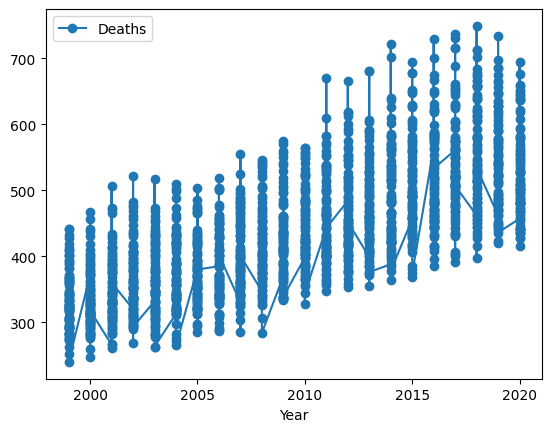

In [25]:
# Plot the number of deaths, excluding 0 values.
deaths_df[deaths_df['Deaths'] != 0].plot(x='Year', y='Deaths', kind='line', marker='o')

Tragically, 720 deaths does not appear to be an outlier as the total number of deaths appears to trend upwards over time.

In [26]:
#Get the number of unique values for each column

deaths_df.nunique()

Notes             0
Year             22
Year Code        22
Month           264
Month Code      264
Weekday           8
Weekday Code      8
Deaths          407
Population        1
Crude Rate        1
dtype: int64

In [27]:
#Calculate number of months expected in the DataFrame
range_years = (2020-1999)
range_months = range_years*12
print('Number of Expected Months:',range_months)

Number of Expected Months: 252


252 months are expected (1999 to 2020 is 21 years. 21 years multiplied by 12 months is 252 months), but there are a total of 264 unique months. It is unclear if this is an artifact of the MMM YYYY formatting, or if unexpected months are included in the range.

### Quality Issue 1: Uniqueness in `powerball_df`

**Issue and justification:** 
*  Several duplicate rows identified in visual inspection.
*  1148 total duplicate rows identified during programaitc inspection. 

During the visual inspection using `.head()` and `.tail()` duplicate entires were observed. During a programatic evaluation using `.duplicated().sum()` 1148 total duplicated rows were found. The duplicates can lead to biased analysis or misinterpretation of results. 
Using head, tail, and sample allow for a quick investigation of the data to assess for indicators of potential errors, such as inconsistency in the data types within a column, inconsistent units or multiple datatypes being stored within a column, repeated values, empty rows or columns. The issue of duplicated values can be confirmed programatically with `.duplicated()`

### Quality Issue 2: Accuracy in `deaths_df`

*  A `'0'` Value is observed in the `Deaths` column during visual assessment of the data corresponding to a value of `'Unkown'` in the `Weekday` column.
*  Programatic assessment of the data indicates that all instances of `'Unknown'` in the `Weekday` column correspond to to `'0'` observations in the `Deaths` column.

**Issue and justification:** The value of `'0'` in the `Deaths` column correpsonding to all isntances of `'Unknown'` demosntrate that `'Unknown'` does not contribute to the analysis of the data, and biases results. A visual inspection using head, sample, and tail allow for the quick assessment of data quality to check for null values, or other placeholders that may be used instead of null (such as "Not Applicable"), and programatetic assessment allows for a count of null and placeholder values to be made. In this case it was demonstrated programatically that the dataset contained 120 `'Unknown'` `Weekday` values, and each of them corresponding to `'0'` `Deaths` indicating these rows do not provide useful information and are likely adversely affecting the analysis.

### Tidiness Issue 1: Each Variable Forms a Column in `powerball_df`

Visual assessment of the data demonstrates that the `Estimated Jackpot` column contains multiple datatypes, a numerical value expressed as currency (e.g. $59) and a units label (e.g. million).

Programatic assessment of the data indicates that labels `'Million'` and `'Billion'` are used, and that each row has one of these labels.

**Issue and justification:** Visual inspection using head, sample, and tail allow for a quick assessment of data tidiness. In this case it demonstrated that `Estimated Jackpot` field is not correctly formatted as currency, and has a numerical value and a units label. Programatic assessment of the data demonstrated one of two possible data labels, and that every field in the `Estimated Jackpot` has a label. This formatting prevents statistical analysis of the field.

### Tidiness Issue 2: Each variable forms a column in `deaths_df`

Visual assessment of the data demonstrates that the `Month` column contains dates and years, such as Mar 1998. Programatic assessment demonstrates 264 unique values in the `Month` column.

**Issue and justification:** Each column is not a single variable. `Month` contains both the month and year, which when combined create a discrete point in time, but limits categorization based on month of the years. Visual inspection of the head, sample, and tail allows for a quick visual assment that this usage is consistent within the dataset, and programatic assessment demonstrates 264 unique values, where in reality there should be 12.

## 3. Clean data

### Cleaning Dataset 1: `powerball_df`
#### Quality Issue 1
*  Duplicated Values
#### Tidyness Issue 1
*  `Estimated Jackpot` holds more than one variable

#### Additional Issue
*  Cast `Drawing Date` as datetime

#### Quality Issue 1: Uniqueness
Remove duplicate rows in `powerball_df`

In [28]:
# Create a new DataFrame based on powerball_df with duplicates removed.
powerball_df_clean = powerball_df.drop_duplicates()

# Count duplicates
powerball_df_clean.duplicated().sum()

0

No duplicates!

The `drop_duplicates()` function was used to simply remove duplicates from the DataFrame. This is an effective option because duplicated values were expected as a result of how the website from which the data was collected handles dates on which there was no drawing (by giving data to the next closest drawing date). Entire rows were duplicated, so no distinciton was needed between duplicates, and the first instance could be kept.

#### Tidiness Issue 1: Each Variable Forms a Column
Seperate data labels from numerical values in the `Expected Jackpot` column and format datatypes correctly

In [29]:
# Extract the numeric part from Jackpot Value
powerball_df_clean['Jackpot Value'] = powerball_df_clean['Estimated Jackpot'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float)

# Extract the unit label from Jackpot Value
powerball_df_clean['Jackpot Unit'] = powerball_df_clean['Estimated Jackpot'].str.extract(r'(Million|Billion)', expand=False)

# Convert all values to millions
powerball_df_clean['Jackpot Value (Millions)'] = powerball_df_clean.apply(
    lambda row: row['Jackpot Value'] * 1000 if row['Jackpot Unit'] == 'Billion' else row['Jackpot Value'],
    axis=1
)

# Drop the Jackpot Value and Jackpot Unit columns since they wont be needed anymore.
powerball_df_clean = powerball_df_clean.drop(columns=['Jackpot Value', 'Jackpot Unit'])

# Display the DataFrame
powerball_df_clean.head()

/tmp/ipykernel_47/1052795941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powerball_df_clean['Jackpot Value'] = powerball_df_clean['Estimated Jackpot'].str.extract(r'(\d+\.?\d*)', expand=False).astype(float)
/tmp/ipykernel_47/1052795941.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  powerball_df_clean['Jackpot Unit'] = powerball_df_clean['Estimated Jackpot'].str.extract(r'(Million|Billion)', expand=False)
/tmp/ipykernel_47/1052795941.py:8: SettingWithCopyWarning: 
A value is trying to be set on 

,Drawing Date,Estimated Jackpot,Jackpot Value (Millions)
0,"Sat, Jan 2, 1999",$40 Million,40.0
2,"Wed, Jan 6, 1999",$45 Million,45.0
3,"Sat, Jan 9, 1999",$51 Million,51.0
5,"Wed, Jan 13, 1999",$58 Million,58.0
6,"Sat, Jan 16, 1999",$67 Million,67.0


In [30]:
# Check the statistical descirptors of the new Jackpot Value column to see 
# that the numbers fall within the expected range
powerball_df_clean['Jackpot Value (Millions)'].describe()

count    2296.000000
mean       92.128920
std        96.575607
min        10.000000
25%        31.000000
50%        61.000000
75%       120.000000
max      1590.000000
Name: Jackpot Value (Millions), dtype: float64

The values in the `Jackpot Value (Millions)` column appear as expected, and the maximum value `'1590'` corresponds to the expected value of 1.59 billion. 

This effectively resolves the issue by removing the labels from the `Estimated Jackpot` field, and isntead converts the numerical value of each to be in the scale of millions. In the case of any value with `'Billion'` the value is multiplied by 1000. This allows for each observation in the new `Jackpot Value (Millions)` column to containt a single variable.

#### Addressing Other Issues with the powerball_df dataset

In [31]:
# Cast Drawing Date as a datetime
powerball_df_clean['Drawing Date'] = pd.to_datetime(powerball_df_clean['Drawing Date'])

# Display the first few rows to confirm the change
powerball_df_clean.head()

,Drawing Date,Estimated Jackpot,Jackpot Value (Millions)
0,1999-01-02,$40 Million,40.0
2,1999-01-06,$45 Million,45.0
3,1999-01-09,$51 Million,51.0
5,1999-01-13,$58 Million,58.0
6,1999-01-16,$67 Million,67.0


In [32]:
#Check datatypes
powerball_df_clean.dtypes

Drawing Date                datetime64[ns]
Estimated Jackpot                   object
Jackpot Value (Millions)           float64
dtype: object

Datatypes are suitable for the purposes of this study. The weekday of drawing was lost when converting `Drawing Date` to a datetime. It is not expected to be needed, but it can easily be calculated from the date if needed in the future.

In [33]:
# Estimated Jackpot column is no longer needed.
powerball_df_clean = powerball_df_clean.drop(columns=['Estimated Jackpot'])

# Look at the first few rows
powerball_df_clean.head()

,Drawing Date,Jackpot Value (Millions)
0,1999-01-02,40.0
2,1999-01-06,45.0
3,1999-01-09,51.0
5,1999-01-13,58.0
6,1999-01-16,67.0


### Cleaning Dataset 2: `deaths_df`
#### Quality Issue 2
*  Accuracy `'Unknown'` in `Weekday` is not needed and biases the dataset, as every instance of `'Unknown'` has 0 observations in the `Deaths` column.
#### Tidyness Issue 2
*  `Month` holds more than one variable

#### Additional Issue
*  Remove irrelavant columns
*  Cast `Month` as a datetime

### Quality Issue 2: Innacurate Data

In [34]:
# Create a clean copy of the dataframe, exluding any rows where Weekday is equal to Unknown.
deaths_df_clean = deaths_df[deaths_df['Weekday'] != 'Unknown']

# Get a statistical description of the Deaths column, as this should have removed all 0 values.

deaths_df_clean['Deaths'].describe()

count    1848.000000
mean      439.247835
std        95.796359
min       240.000000
25%       364.750000
50%       430.000000
75%       502.000000
max       749.000000
Name: Deaths, dtype: float64

By removing the 0 values the mean has increased to 439.25 and the standard deviation has decreased to 95.80. The max value of 749 is now 3.2 standard deviations from the mean. However this still fits within the expected trend of the dataset.

All zero values were removed from the `Deaths` column by excluding all rows with and `'Unknown'` value in the `Weekday` column. Assessment of the data demonstrated that all rows with `'Unknown'` in `Weekday` always had `'0'` observations in `Deaths` so exluding any rows where `Weekday` was equal to `'Unknown'` is effective for removing the innacurate data.

In [35]:
deaths_df['Deaths'].describe()

count    1968.000000
mean      412.464431
std       140.249443
min         0.000000
25%       351.750000
50%       421.000000
75%       495.000000
max       749.000000
Name: Deaths, dtype: float64

### Tidyness Issue 2: `Month` column has multiple variables
The month column is functioning more like a truncated date by giving the date and year instead of just the month.

This dataset has a limitation compared to the Powerball Drawings dataset: to protect privacy, the CDC only provides time data by weekday, not by specific calendar days. This means that each weekday could represent up to five different days within a month, making it impossible to match directly to a specific Powerball drawing.

To address this, the dataset will be aggregated by month, summing up the total deaths. This will address the tidyness issue, and prepare the dataset to be combined with the Powerball data which will also be aggrated by month with the mean jackpot value.

In the deaths_df the columns `Notes` `Population` and `Crude Rate` were demonstrated to be irrelevant, containing null values, or placeholder null values. In aggregating the dataframe these columns will be excluded. Additionally, `Year` `Year Code` `Month Code` `Weekday` and `Weekday Code` will be exlcuded, as they will no longer be relevant when considering only monthly aggregations.

In [36]:
deaths_df.head()

,Notes,Year,Year Code,Month,Month Code,Weekday,Weekday Code,Deaths,Population,Crude Rate
0,NaN,1999,1999,"Jan., 1999",1999/01,Sunday,1,367,Not Applicable,Not Applicable
1,NaN,1999,1999,"Jan., 1999",1999/01,Monday,2,356,Not Applicable,Not Applicable
2,NaN,1999,1999,"Jan., 1999",1999/01,Tuesday,3,321,Not Applicable,Not Applicable
3,NaN,1999,1999,"Jan., 1999",1999/01,Wednesday,4,321,Not Applicable,Not Applicable
4,NaN,1999,1999,"Jan., 1999",1999/01,Thursday,5,326,Not Applicable,Not Applicable


In [37]:
# Aggregate deaths_df by Month, taking the sum of the Deaths column for each month.


# Remove the period from the Month column in deaths_df_clean so it can be cast as a datetime
deaths_df_clean['Month'] = deaths_df['Month'].str.replace('.', '', regex=False)

# Cast Month as datetime
deaths_df_clean['Month'] = pd.to_datetime(deaths_df_clean['Month'])

# Group by Month, summing Deaths
deaths_df_clean = deaths_df_clean.groupby(['Month'], as_index=False)['Deaths'].sum()

# Look at the first few rows
deaths_df_clean.head()

/tmp/ipykernel_47/52007947.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_df_clean['Month'] = deaths_df['Month'].str.replace('.', '', regex=False)
/tmp/ipykernel_47/52007947.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  deaths_df_clean['Month'] = pd.to_datetime(deaths_df_clean['Month'])
/tmp/ipykernel_47/52007947.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

,Month,Deaths
0,1999-01-01,2398
1,1999-02-01,2211
2,1999-03-01,2354
3,1999-04-01,2381
4,1999-05-01,2433


In [38]:
# Based on a limitation of the datatype datetime must include a day. 
# Rename the column to month_start for clarification

deaths_df_clean.rename(columns={'Month': 'month_start'}, inplace=True)

#Look at the first few reows to evaluate effect of rename
deaths_df_clean.head()

,month_start,Deaths
0,1999-01-01,2398
1,1999-02-01,2211
2,1999-03-01,2354
3,1999-04-01,2381
4,1999-05-01,2433


### Update `powerball_df_clean` and Merge DataFrames

In [39]:
## powerball_df_clean will be aggregated by month.
## extract the Month and Year from the date
powerball_df_clean['Year-Month'] = powerball_df_clean['Drawing Date'].dt.to_period('M')

# Check the results
powerball_df_clean.head()

,Drawing Date,Jackpot Value (Millions),Year-Month
0,1999-01-02,40.0,1999-01
2,1999-01-06,45.0,1999-01
3,1999-01-09,51.0,1999-01
5,1999-01-13,58.0,1999-01
6,1999-01-16,67.0,1999-01


In [40]:
# Aggregate the values and take the mean of the jackpot value for each month.
powerball_df_clean = powerball_df_clean.groupby(['Year-Month'], as_index=False)['Jackpot Value (Millions)'].mean()

# Look at the result
powerball_df_clean.head()

,Year-Month,Jackpot Value (Millions)
0,1999-01,34.777778
1,1999-02,17.875000
2,1999-03,40.333333
3,1999-04,24.375000
4,1999-05,23.000000


In [41]:
# Cast Year-Month as a datetime in a column named month_start to align with deaths_df_clean dataframe
powerball_df_clean['month_start'] = pd.to_datetime(powerball_df_clean['Year-Month'].astype(str), format='%Y-%m')

# Drop the Year-Month column
powerball_df_clean.drop(columns=['Year-Month'], inplace=True)

# Look at the result
powerball_df_clean.head()

,Jackpot Value (Millions),month_start
0,34.777778,1999-01-01
1,17.875000,1999-02-01
2,40.333333,1999-03-01
3,24.375000,1999-04-01
4,23.000000,1999-05-01


In [42]:
# Rename Jackpot Value (Millions) to be more consistent
powerball_df_clean.rename(columns={'Jackpot Value (Millions)': 'jackpot_millions'}, inplace=True)

# Look at the results
powerball_df_clean.head()

,jackpot_millions,month_start
0,34.777778,1999-01-01
1,17.875000,1999-02-01
2,40.333333,1999-03-01
3,24.375000,1999-04-01
4,23.000000,1999-05-01


In [43]:
# Merge the dataframes
df = pd.merge(powerball_df_clean, deaths_df_clean, on='month_start', how='inner')

# look at the first few rows of the merged df
df.head()

,jackpot_millions,month_start,Deaths
0,34.777778,1999-01-01,2398
1,17.875000,1999-02-01,2211
2,40.333333,1999-03-01,2354
3,24.375000,1999-04-01,2381
4,23.000000,1999-05-01,2433


In [44]:
# Move month_start to be the first column
cols = ['month_start'] + [col for col in df if col != 'month_start']
df = df[cols]

# Check the results
df.head()

,month_start,jackpot_millions,Deaths
0,1999-01-01,34.777778,2398
1,1999-02-01,17.875000,2211
2,1999-03-01,40.333333,2354
3,1999-04-01,24.375000,2381
4,1999-05-01,23.000000,2433


## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [45]:
#save the DataFrame to a CSV
df.to_csv('merged_df.csv', index=False)

## 5. Answer the research question

### **5.1:** Define and answer the research question 
Going back to the problem statement in step 1, use the cleaned data to answer the question you raised. Produce **at least** two visualizations using the cleaned data and explain how they help you answer the question.

*Research question:* FILL IN from answer to Step 1

In [46]:
# Normalize the data for easier plotting
scaler = MinMaxScaler()
df[['jackpot_millions', 'Deaths']] = scaler.fit_transform(df[['jackpot_millions', 'Deaths']])
#Check the Results
df.head()

,month_start,jackpot_millions,Deaths
0,1999-01-01,0.047559,0.116889
1,1999-02-01,0.009279,0.027672
2,1999-03-01,0.060141,0.095897
3,1999-04-01,0.024000,0.108779
4,1999-05-01,0.020886,0.133588


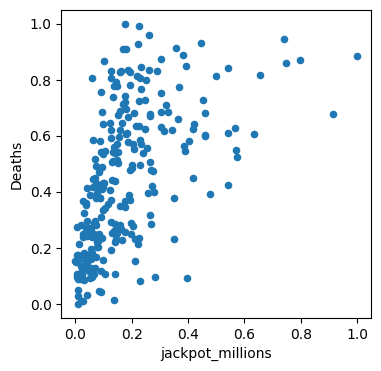

In [47]:
df.plot(x='jackpot_millions', y='Deaths', kind='scatter', figsize=(4,4));


*Answer to research question:* FILL IN

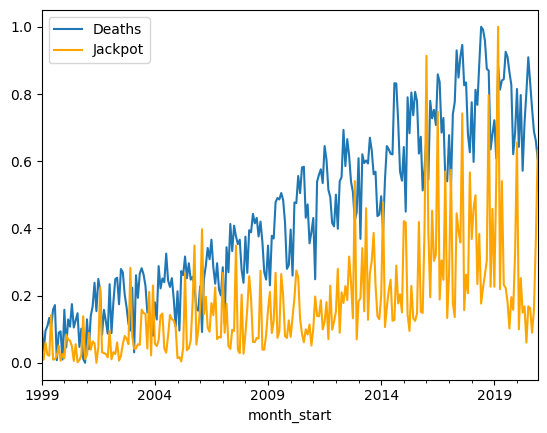

In [48]:
# Plot date and deaths
ax = df.plot(x='month_start', y='Deaths', label='Deaths')

# Plot the second line on the same axes
df.plot(x='month_start', y='jackpot_millions', ax=ax, label='Jackpot', color='orange')

# Display the legend
ax.legend();

In [49]:
#Calculate the correlation coefficient
correlation = df['jackpot_millions'].corr(df['Deaths'])
print(f"Correlation coefficient: {correlation}")

Correlation coefficient: 0.5572702534729437


**Answer to research question:** While there may be anecdotal cases of suicide attributed to losing a high-value Powerball lottery drawing, the available data does not demonstrate a significant correlation. The scatter plot, line graph, and correlation coefficient indicate a moderate correlation between monthly deaths by suicide and the average monthly Powerball jackpot value.

The correlation coefficient of 0.56 suggests a moderate relationship. However, this correlation might be influenced by an increase in population over time rather than a direct causal relationship. I believe additional study is warranted. Evaluating data on deaths by suicide per week or calendar day (if it becomes available) could provide the necessary detail to assess whether there is a stronger correlation between suicide deaths and larger Powerball jackpots. 

### **5.2:** Reflection
In 2-4 sentences, if you had more time to complete the project, what actions would you take? For example, which data quality and structural issues would you look into further, and what research questions would you further explore?

*Answer:* 
Given more time I would look at 
* Individual drawings against the average number of suicide deaths in that month
* Tickets may be purchased for several drawings at a time. If a ticket is purchased for Monday, Wednseday, and conlcudes on Satuday, I would expect to see an increase in suicide deaths on Saturdays only. Evaluating only the deaths on Saturdays or only on the days of drawings may provide an additional layer of insight.
* I would like to have found a better data source that gives suicide deaths by week or calendar day.
* Limit the data only to states where the lottery is played.
